# Importing libraries

In [61]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import time
import math
import random
import itertools

# Scientific and data processing libraries
import numpy as np
import pandas as pd
from scipy.special import comb

# Graph and clustering libraries
import networkx as nx
import metis
import distinctipy

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Progress bar
from tqdm import tqdm

# Machine learning and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

# Dataset

<AxesSubplot:>

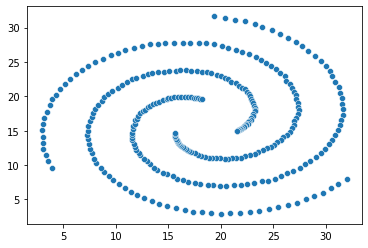

In [62]:
# Load dataset
dataset = pd.read_csv(r'/Users/sajal/Downloads/Ch2++/Standard Benchmark Datasets/3-spiral.csv')

# Clean and rename columns
dataset.columns = dataset.columns.str.lower()
dataset = dataset.rename(columns={'a0': 'x', 'a1': 'y'})

# Set initial parameters
knn = int(math.log(len(dataset)))  # k: number of neighbors in k-NN graph
no = dataset['class'].nunique()         # number of final clusters
part = max(knn, 2 * no)                # number of partitions (used as i/p incase of hMETIS)

# Prepare data
df = dataset[['x', 'y']]
true = dataset['class']
plot = dataset.to_numpy()

# Plot dataset
sns.scatterplot(x=plot[:, 0], y=plot[:, 1])  # Dataset Plot
# sns.scatterplot(x=plot[:, 0], y=plot[:, 1], hue=true)  # Ground-Truth Plot

# k-NN Graph Generation: Exact k-NN

Building k-NN (knn = 5)...


100%|████████████████████████████████████████| 312/312 [00:01<00:00, 215.98it/s]


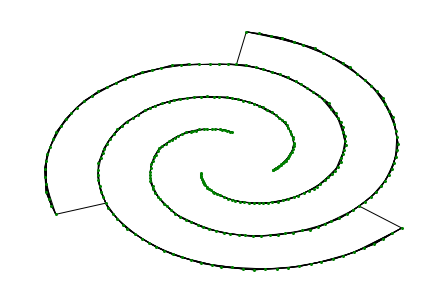

In [63]:
def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def knn_graph(df, knn, verbose=False):
    points = [p[1:] for p in df.itertuples()]
    g = nx.Graph()

    for i in range(len(points)):
        g.add_node(i)

    if verbose:
        print(f"Building k-NN (knn = {knn})...")

    iterpoints = tqdm(enumerate(points), total=len(points)) if verbose else enumerate(points)

    for i, p in iterpoints:
        distances = list(map(lambda x: euclidean_distance(p, x), points))
        closests = np.argsort(distances)[1:knn + 1]

        for c in closests:
            if distances[c] == 0:
                continue
            weight = 1.0 / distances[c]
            g.add_edge(i, c, weight=weight, similarity=int(weight * 1e3))

        g.nodes[i]['pos'] = p

    g.graph['edge_weight_attr'] = 'similarity'
    return g


def plot2d_graph(graph):
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos, node_size=4.3, node_shape='x', node_color='green')
#     plt.savefig('Exact k-NN', dpi=500) # incase to save o/p locally
    plt.show(block=True)


graph = knn_graph(df, knn, verbose=True)
n = graph.number_of_nodes()
m = graph.number_of_edges()
pos = nx.get_node_attributes(graph, 'pos') #co-ordinates of each node
plot2d_graph(graph)

# Graph Partitioning : hMETIS

In [64]:
def pre_part_graph(graph, k, df=None, verbose=False):
    if verbose:
        print("Begin Partitioning...")
        start = time.time()

    # Use recursive=False for speed and efficiency with large k: METIS (Multi k-way)
    # Use recursive=True (default) if you care more about partition quality and can afford the extra time.
    
    # Perform graph partitioning using METIS (recursive=True? Recursive:Multi-k-way)
    edgecuts, parts = metis.part_graph(graph, k, recursive=False)

    if verbose:
        print("Partitioned in", time.time() - start, "seconds")
        print("Number of partitions:", len(set(parts)))
        print(f"Partitioned graph into {k} parts with {edgecuts} edge cuts")

    global hmetis
    hmetis = parts

    # Assign partition numbers to nodes in the graph
    for i, part in enumerate(parts):
        graph.nodes[i]['cluster'] = part

    # Assign clusters in dataframe
    if df is not None:
        df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()

    return graph


graph = pre_part_graph(graph, part, df, verbose=True)

Begin Partitioning...
Partitioned in 0.011042118072509766 seconds
Number of partitions: 6
Partitioned graph into 6 parts with 15616 edge cuts


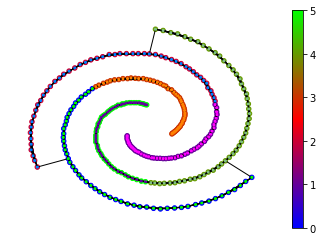

#Partitions generated post hMETIS: 6


In [65]:
# Visualize Partitions
df.plot(kind='scatter', x=0, y=1, c=df['cluster'], cmap='brg')

# Color nodes based on partitions
colors = distinctipy.get_colors(part)
clusters = nx.get_node_attributes(graph, 'cluster').values()
c = [colors[i % len(colors)] for i in clusters]

nx.draw(graph, pos, node_size=4.3, node_color=c, node_shape='x')
plt.show(block=True)

print("#Partitions generated post hMETIS:", part)

# Optimal/Custom Visualization

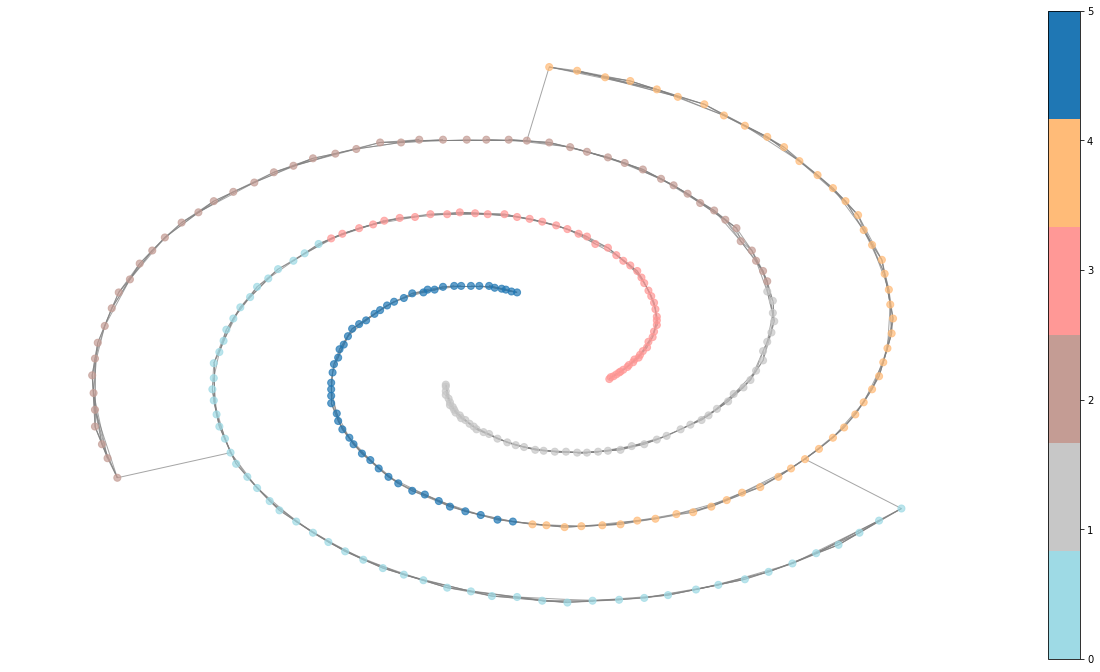

In [66]:
# Generate a color map
unique_clusters = df['cluster'].unique()  # Get unique cluster labels
num_clusters = len(unique_clusters)  # Count the number of unique clusters
cmap = cm.get_cmap('tab20_r', num_clusters)  # Use a colormap with distinct colors

# Map nodes to colors based on their cluster
node_colors = [cmap(i) for i in nx.get_node_attributes(graph, 'cluster').values()]

plt.figure(figsize=(17, 9))
nx.draw(
    graph, 
    pos, 
    node_size=50,  # Adjust node size for visibility
    node_color=node_colors, 
    edge_color='gray',  # Set edge color
    alpha=0.7,  # Slightly transparent edges for a cleaner look
    with_labels=False  # Omit labels for better readability in larger graphs
)

# plt.title("hMETIS : #partitions = 14", fontsize=16)
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_clusters - 1)))
plt.show()

# Partition Refinement : Flood Fill

In [67]:
# Initialize empty partitions based on the number of partitions
ff = [[] for _ in range(part)]

# Assign nodes to corresponding partitions: # use 'partitions' variable for FM and 'hmetis' for hMETIS partitioning
for i, val in enumerate(hmetis):
    ff[val].append(i)

# Function to refine partitions by connected components
def refine_partitions(graph, partition_indices):
    partitions = []
    for cluster_nodes in partition_indices:
        subgraph = graph.subgraph(cluster_nodes)  # Create subgraph for each partition
        connected_components = list(nx.connected_components(subgraph))  # Find connected components
        partitions.extend(connected_components)  # Add connected components to the partitions list
    return partitions

# Refine the partitions based on connected components
refined_partitions = refine_partitions(graph, ff)

# Get the number of refined partitions
part = len(refined_partitions)

# Update the node attributes with the refined partition information
for i, nodes in enumerate(refined_partitions):
    for node in nodes:
        graph.nodes[node]['cluster'] = i

# Update the DataFrame with the new cluster information
df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()

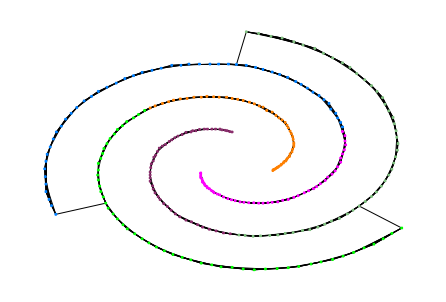

#Partitions post Flood-Fill: 6


In [68]:
colors = distinctipy.get_colors(part)
c = [colors[i % (len(colors))] for i in nx.get_node_attributes(graph, 'cluster').values()]
nx.draw(graph, pos, node_size=4.3, node_color=c, node_shape='x')
plt.show(block=True)

print("#Partitions post Flood-Fill:", len(df['cluster'].unique()))

# Parameter Check

In [69]:
print(f"no (final #clusters): {no}")
print(f"knn (k nearest neighbors): {knn}")
print(f"part (#partitions post flood fill): {part}")
print(f"n (#nodes): {n}")
print(f"m (#edges): {m}")

no (final #clusters): 3
knn (k nearest neighbors): 5
part (#partitions post flood fill): 6
n (#nodes): 312
m (#edges): 865


# Merging Criteria: Ch2

In [70]:
def get_cluster(graph, clusters):
    nodes = [n for n in graph.nodes if graph.nodes[n]['cluster'] in clusters]
    return nodes

def connecting_edges(partitions, graph):
    cut_set = []
    for a in partitions[0]:
        for b in partitions[1]:
            if a in graph:
                if b in graph[a]:
                    cut_set.append((a, b))
    return cut_set

def get_weights(graph, edges):
    return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

def s_ci(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    weights = get_weights(cluster, edges)
    return np.sum(weights)


def E_ci(graph,cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    return len(edges)

def s_ci_avg(graph, cluster):
    sci = s_ci(graph, cluster)
    Eci = E_ci(graph, cluster)
    return (sci/Eci)

def s_cij_avg(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    weights = get_weights(graph, edges)
    return np.mean(weights)

def E_cij(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    return len(edges)

def p_cij(graph, cluster_i, cluster_j):
    scia = s_ci_avg(graph, cluster_i)
    scja = s_ci_avg(graph, cluster_j)
    min_sci_scj_a = min(scia, scja)
    max_sci_scj_a = max(scia, scja)
    return (min_sci_scj_a/max_sci_scj_a)

def rc(graph, cluster_i, cluster_j):
    eci = E_ci(graph, cluster_i)
    ecj = E_ci(graph, cluster_j)
    sci = s_ci(graph, cluster_i)
    scj = s_ci(graph, cluster_j)
    scija = s_cij_avg(graph, cluster_i, cluster_j)
    common_fact = scija/(sci + scj)
    
    rcl_val = 0
    mfact = 1e3
    if (eci==0 or ecj==0):
        rcl_val = mfact* common_fact
    else:
        rcl_val = (eci + ecj)*common_fact
    return rcl_val

def ri(graph, cluster_i, cluster_j):
    eci = E_ci(graph, cluster_i)
    ecj = E_ci(graph, cluster_j)
    ecij = E_cij(graph, cluster_i, cluster_j)
    pcij = p_cij(graph, cluster_i, cluster_j)
    
    ri_val = 0
    beta = 1.0  # default parameter value: Beta = 1.0
    if (eci==0 or ecj==0):
        ri_val = 1
    else:
        ri_val = (ecij/(min(eci, ecj))) * np.power(pcij, beta)
    return ri_val

def merge_score(g, ci, cj, a):
    return ri(g, ci, cj) * np.power(rc(g, ci, cj), a)

def merge_best(graph, df, a, k, verbose=False):
    clusters = np.unique(df['cluster'])
    max_score = 0
    ci, cj = -1, -1
    if len(clusters) <= k:
        return False

    for combination in itertools.combinations(clusters, 2): # Write a heuristic* [use priority queue, rather than brute force]
        i, j = combination
        if i != j:
            if verbose:
                print("Checking c%d c%d" % (i, j))
            gi = get_cluster(graph, [i])
            gj = get_cluster(graph, [j])
            edges = connecting_edges(
                (gi, gj), graph)
            if not edges:
                continue
            ms = merge_score(graph, gi, gj, a)
            if verbose:
                print("Merge score: %f" % (ms))
            if ms > max_score:
                if verbose:
                    print("Better than: %f" % (max_score))
                max_score = ms
                ci, cj = i, j

    if max_score > 0:
        if verbose:
            print("Merging c%d and c%d" % (ci, cj))
        df.loc[df['cluster'] == cj, 'cluster'] = ci
        for i, p in enumerate(graph.nodes()):
            if graph.nodes[p]['cluster'] == cj:
                graph.nodes[p]['cluster'] = ci
    return max_score > 0

In [71]:
start = time.time()
# Iterate over the number of partitions left to merge
iterm = tqdm(enumerate(range(part - no)), total=part - no)
for i in iterm:
    merge_best(graph, df, 2.0, no, False) # default parameter value: Alpha = 2.0
print(f"Merged in {time.time() - start:.2f} seconds")

clusters = len(np.unique(df['cluster']))
print(f"Number of clusters after merging: {clusters}")

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]

Merged in 0.84 seconds
Number of clusters after merging: 3


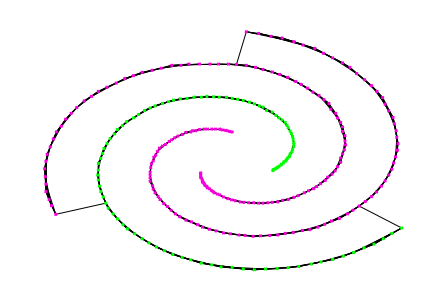

In [72]:
# Automatically determine the maximum number of colors needed based on the number of clusters
max_color = clusters
colors = distinctipy.get_colors(max_color)
c = [colors[i % len(colors)] for i in nx.get_node_attributes(graph, 'cluster').values()]
nx.draw(
    graph,
    pos,
    node_size=6.3,
    node_color=c,
    node_shape='x'
)
plt.show(block=True)

In [73]:
# Function to rebuild cluster labels and reassign them incrementally
def rebuild_labels(df):
    ans = df.copy()  # Create a copy of the DataFrame
    clusters = list(pd.DataFrame(df['cluster'].value_counts()).index)  # Get list of unique clusters
    c = 1  # Initialize the new label counter
    for i in clusters:
        # Reassign the 'cluster' label incrementally
        ans.loc[df['cluster'] == i, 'cluster'] = c
        c += 1  # Increment the counter for the next label
    return ans

# Rebuild labels for the DataFrame
ans = rebuild_labels(df)

# Standardize the features 'x' and 'y' using StandardScaler
z = StandardScaler()
score = dataset[['x', 'y']]
score[['x', 'y']] = z.fit_transform(score)

# Extract predicted cluster labels
predicted = ans['cluster'].to_numpy()

# Calculate and print evaluation metrics
print("NMI-Score:", normalized_mutual_info_score(true, predicted))
print("Rand-Score:", adjusted_rand_score(true, predicted))

NMI-Score: 1.0
Rand-Score: 1.0
